# Подготовка к работе

Импортируем необходимые библиотеки и вводим переменные

In [ ]:
import os
from typing import List, Tuple
import networkx as nx

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
import cv2
import torch

# Audio
import librosa

# Video
import clip
from PIL import Image
import scenedetect
from moviepy import VideoFileClip
from scenedetect.detectors import ContentDetector
from scenedetect.scene_manager import SceneManager

# Detection
from ultralytics import YOLO
from insightface.app import FaceAnalysis

In [15]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
FILENAME = 'one_alone'      # full move
# FILENAME = 'one_alone_t'  # trailer

SOURCES_PATH = './sources/'
VIDEO_PATH = SOURCES_PATH + FILENAME + '.mp4'
AUDIO_PATH = SOURCES_PATH + FILENAME + '.wav'

Видео необходимо поместить по пути `VIDEO_PATH`. Предлагается воспользоваться загрузкой видео с платформы YouTube или же поместить собственное видео самостоятельно  

In [7]:
from pytube import YouTube

def download_from_youtube(url):
    yt = YouTube(url)
    
    yt.streams.filter(
        file_extension='mp4',                           # expected extension
        progressive=True                                # download video + audio
    ).order_by('resolution').desc().first().download(   # sorted by resolution (360p, 720p, 1080p...) in desc and get first the highest
        output_path=os.path.dirname(VIDEO_PATH),
        filename=os.path.basename(VIDEO_PATH)
    )

    return yt

In [4]:
def extract_audio():
    video = VideoFileClip(VIDEO_PATH)
    audio = video.audio
    audio.write_audiofile(AUDIO_PATH, codec='pcm_s16le')

extract_audio()

MoviePy - Writing audio in ./sources/one_alone.wav


MoviePy - Done.


# Сценарная сегментация

Имплементируем класс для дальнейших визуализаций результатов

In [5]:
class Visualizator:
    def plot_audio_metadata(audio_metadata):
        plt.figure(figsize=(15, 10))

        plt.subplot(3, 1, 1)
        plt.plot(audio_metadata['time_axis'], audio_metadata['rms'], label='RMS Energy')
        plt.title('Normalized RMS Energy')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')

        plt.subplot(3, 1, 2)
        plt.plot(audio_metadata['time_axis'], audio_metadata['spectral_centroid'], label='Spectral Centroid', color='orange')
        plt.title('Normalized Spectral Centroid')
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency')

        plt.subplot(3, 1, 3)
        plt.plot(audio_metadata['time_axis'], audio_metadata['zcr'], label='Zero Crossing Rate', color='green')
        plt.title('Zero Crossing Rate')
        plt.xlabel('Time (s)')
        plt.ylabel('Rate')

        plt.tight_layout()
        plt.show()

    def scenes_statistic(scenes_time, where):
        print(f'Detected {len(scenes_time)} scenes in {where}:')

        for i, (start, end) in enumerate(scenes_time):
            print(f"\t- scene #{i+1}: {start:.2f} - {end:.2f} ({(end-start):.2f} sec)")

    def show_middle_frame_of_ten(ten_scenes):
        fig, axes = plt.subplots(2, 5, figsize=(20, 8))
        axes = axes.flatten()

        for i, (start, end) in enumerate(ten_scenes):
            mid_time = (start + end) / 2
            cap = cv2.VideoCapture(VIDEO_PATH)
            cap.set(cv2.CAP_PROP_POS_MSEC, mid_time * 1000)
            ret, frame = cap.read()
            cap.release()

            if ret:
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                axes[i].imshow(frame_rgb)
                axes[i].set_title(f"Scene {i+1}\n{end-start:.2f}s")
                axes[i].axis('off')
            else:
                axes[i].text(0.5, 0.5, "No frame", ha='center', va='center')
                axes[i].axis('off')

        plt.tight_layout()
        plt.show()

    def visualize_scenes(final_scenes, video_path):
        cap = cv2.VideoCapture(video_path)

        plt.figure(figsize=(15, 5))

        # Scene visualize
        for i, (start, end) in enumerate(final_scenes):
            plt.axvspan(start, end, alpha=0.3, color=f'C{i}', label=f'Scene {i+1}')

        plt.title('Scenes segmentation')
        plt.xlabel('Time, sec')
        plt.ylabel('Scenes')
        plt.show()
        cap.release()

Имплементируем основной класс для сценарной сегментации. В рамках задачи будем использовать классические cv методы, а также эмбеддинги сцен CLIP для финальной сегментации.

Разделим сегментацию на три этапа:
1. Сегментация по аудио:
    - Выделение метаданных в аудио
    - Сегментация на сцены по метаданным
2. Сегментация по видео
    - Определение сцен по видео
    - Объединение визуальных сцен на основе выделенных отрезков
3. Коллаборация решений для финального определения сцен
    - Семантическое объединение сцен
    - Финальное объединение на основе CLIP

In [ ]:
class SceneDetector:
    def __init__(
        self, audio_path: str, video_path: str, 
        video_weight: float=None, audio_weight: float=None
    ):
        self.audio_path = audio_path
        self.video_path = video_path

        self.video_weight = video_weight 
        self.audio_weight = audio_weight

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.m_clip, self.m_preproc = clip.load("ViT-B/32", self.device)

        self.cap = cv2.VideoCapture(self.video_path)


    def _get_keyframe(self, start: float, end: float):
        """
        Take one characteristic frame from the middle of the scene for compare only one.
        The goal is to avoid comparing all the frames (which is incredibly expensive)
        """

        final_frame = None
        mid = (start + end) / 2
        self.cap.set(cv2.CAP_PROP_POS_MSEC, mid * 1000)
        ret, frame = self.cap.read()
        if ret:
            final_frame = frame
        return final_frame


    def _hist_distance(self, img1, img2):
        dist = 1.0
        if not (img1 is None or img2 is None):
            img1_hsv = cv2.cvtColor(img1, cv2.COLOR_BGR2HSV)
            img2_hsv = cv2.cvtColor(img1, cv2.COLOR_BGR2HSV)
            h1 = cv2.calcHist([img1_hsv], [0,1,2], None, [8,8,8], [0,180,0,256,0,256])
            h2 = cv2.calcHist([img2_hsv], [0,1,2], None, [8,8,8], [0,180,0,256,0,256])
            cv2.normalize(h1, h1)
            cv2.normalize(h2, h2)
            dist = cv2.compareHist(h1, h2, cv2.HISTCMP_BHATTACHARYYA)
        return dist


    def _get_frame_embedding(self, frame):
        # frame: BGR OpenCV
        image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        image_input = self.m_preproc(image).unsqueeze(0).to(self.device)
        with torch.no_grad():
            emb = self.m_clip.encode_image(image_input)
            emb = emb[0].cpu().numpy()
        return emb
    

    def _cosine_similarity(self, a, b):
        a_norm = a / np.linalg.norm(a)
        b_norm = b / np.linalg.norm(b)
        return np.dot(a_norm, b_norm)
    

    def get_audio_analysis(self, frame_length: int=2048, hop_length: int=512) -> dict:
        """
        Extract three key characteristics of sound frame by frame

        Args:
            frame_length (int, optional): lenght of frame. Defaults to 2048.
            hop_length (int, optional): Shift between windows. Defaults to 512.

        Returns:
            dict: audio metadata
        """        
        # Get wave amplitude (y) and sampling frequency, Hz (sr).
        y, sr = librosa.load(self.audio_path)
        print('Loaded audio')

        # Calculate RMS energy - volume: 0=silence, 1=maximum.
        rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]
        rms_normalized = (rms - np.min(rms)) / (np.max(rms) - np.min(rms))
        print('RMS audio')

        # Calculate spectral centroid (brightness/pitch)
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=frame_length, hop_length=hop_length)[0]
        spectral_centroid_normalized = \
            (spectral_centroid - np.min(spectral_centroid)) / (np.max(spectral_centroid) - np.min(spectral_centroid))
        print('Spectral centroid audio')

        # Calculate Zero Crossing Rate (noise/sound type)
        zcr = librosa.feature.zero_crossing_rate(y, frame_length=frame_length, hop_length=hop_length)[0]
        print('ZCR audio')

        # Get time axis in seconds for visualization
        time_axis = librosa.times_like(rms, sr=sr, hop_length=hop_length, n_fft=frame_length)
        print('Times audio')

        audio_metadata = {
            'time_axis': time_axis,
            'rms': rms_normalized,
            'spectral_centroid': spectral_centroid_normalized,
            'zcr': zcr
        }
        return audio_metadata
    

    def detect_audio_scenes(
        self, audio_metadata: dict, rms_threshold: float=0.3, 
        centroid_threshold: float=0.4, min_scene_duration: float=3.0
    )  -> List[Tuple[float]]:
        """
        Detects audio scene changes based on sharp changes in loudness (RMS) 
        and sound "brightness" (spectral centroid) in the data

        Args:
            audio_metadata (dict): 
                audio metadata after self.get_audio_analysis
            rms_threshold (float, optional): Defaults to 0.3. 
                loudness change threshold. Normalized RMS difference (0-1)
            centroid_threshold (float, optional): Defaults to 0.4.
                brightness change threshold. Spectral centroid difference (0-1)
            min_scene_duration (float, optional): Defaults to 3.0.
                minimum scene length. Filters out noise "blinks."

        Returns:
            List[Tuple[float]]: the beginning and end of each scene
        """        
        audio_scenes = []
        current_scene_start = 0.0

        for i in tqdm(range(1, len(audio_metadata['time_axis']))):
            # Detect big changes in rsm and spectral_centroid
            rms_change = abs(audio_metadata['rms'][i] - audio_metadata['rms'][i-1])
            centroid_change = abs(
                audio_metadata['spectral_centroid'][i] - audio_metadata['spectral_centroid'][i-1]
            )

            if (rms_change > rms_threshold \
                or centroid_change > centroid_threshold) \
                and (audio_metadata['time_axis'][i] - current_scene_start) >= min_scene_duration:
                # Define it as new scene
                audio_scenes.append((current_scene_start, audio_metadata['time_axis'][i]))
                current_scene_start = audio_metadata['time_axis'][i]

        # Add last scene
        if current_scene_start < audio_metadata['time_axis'][-1]:
            audio_scenes.append((current_scene_start, audio_metadata['time_axis'][-1]))

        return audio_scenes
    

    def detect_video_scenes(self, threshold=30.0) -> List[Tuple[float]]:
        """
        Detects scene changes in videos (moments when the camera switches to a new frame, 
        such as a change in location, lighting, or movement). It uses the PySceneDetect 
        library, which analyzes frames and identifies "breaks" based on changes in content.

        Args:
            threshold (float, optional): Defaults to 30.0.
                Detector sensitivity. The measure of change between frames (0-100).
                Lower values == more scenes (catches subtle transitions), 
                higher values == fewer scenes (only sharp cuts).

        Returns:
            List[Tuple[float]]: the beginning and end of each scene
        """        
        # Read frames and find scenes with changes based on the difference in pixels between frames
        video = scenedetect.VideoManager([self.video_path])
        scene_manager = SceneManager()
        scene_manager.add_detector(ContentDetector(threshold=threshold))
        print('Get video')

        # Reduces the resolution to speed up analysis, detect and get list of scenes
        video.set_downscale_factor()
        video.start()
        scene_manager.detect_scenes(frame_source=video)
        scene_list = scene_manager.get_scene_list()
        print('Detected scenes')

        # Convert to seconds
        video_scenes = []
        for scene in scene_list:
            start_time = scene[0].get_seconds()
            end_time = scene[1].get_seconds()
            video_scenes.append((start_time, end_time))

        return video_scenes
    

    def detect_visual_scenes(
        self,
        video_scenes,
        hist_threshold=0.35,       # the less, the stricter
        min_scene_len=2.0,         # sec
        max_scene_len=20.0         # protection against sticking of everything
    ):
        """
        Go through the video sequentially and splice together adjacent scenes if:
            - they are visually similar (base on self._hist_distance)
            - there are no abrupt changes
            - their duration is not suspiciously long
        """    
        visual_scenes = []

        current_start, current_end = video_scenes[0]
        prev_frame = self._get_keyframe(current_start, current_end)

        for start, end in tqdm(video_scenes[1:]):
            frame = self._get_keyframe(start, end)
            dist = self._hist_distance(prev_frame, frame)
            cur_len = current_end - current_start

            if dist < hist_threshold and cur_len < max_scene_len:
                current_end = end
            else:
                # final current visual scene
                if (current_end - current_start) >= min_scene_len:
                    visual_scenes.append((current_start, current_end))
                current_start, current_end = start, end

            prev_frame = frame

        visual_scenes.append((current_start, current_end))
        return visual_scenes

    
    def build_semantic_scenes(
        self,
        audio_scenes: List[Tuple[float]],
        visual_scenes: List[Tuple[float]],
        min_visual_len: float=6.0,
        min_block_len: float=10.0
    ) -> List[Tuple[float]]:
        """
        For each audio scene detect all the visual scenes within it
        and create a new semantic block:

            - at the beginning of the audio scene
            - at the audio boundary
            - at the confirmed visual boundary

        Args:
            audio_scenes (List[Tuple[float]]): [(start, end)]
            visual_scenes (List[Tuple[float]]): [(start, end)]
            min_visual_len (float, optional): Defaults to 6.0.
            min_block_len (float, optional): Defaults to 10.0.

        Returns:
            List[Tuple[float]]: the beginning and end of each scene
        """

        semantic_blocks = []

        for a_start, a_end in audio_scenes:
            # visual scenes inside this audio scene
            visuals = [
                (v_start, v_end)
                for v_start, v_end in visual_scenes
                if v_end > a_start and v_start < a_end
            ]

            # clip to audio bounds
            visuals = [
                (max(v_start, a_start), min(v_end, a_end))
                for v_start, v_end in visuals
            ]

            current_start = a_start

            for v_start, v_end in visuals:
                v_len = v_end - v_start

                # candidate boundary
                if v_len >= min_visual_len:
                    block_len = v_start - current_start

                    if block_len >= min_block_len:
                        semantic_blocks.append((current_start, v_start))
                        current_start = v_start

            # tail
            if a_end - current_start >= min_block_len:
                semantic_blocks.append((current_start, a_end))
            else:
                # attach short tail to previous
                if semantic_blocks:
                    prev_start, _ = semantic_blocks[-1]
                    semantic_blocks[-1] = (prev_start, a_end)
                else:
                    semantic_blocks.append((current_start, a_end))

        return semantic_blocks


    def merge_scenes_cosine(
        self, semantic_blocks: List[Tuple[float]],
        similarity_threshold=0.85, min_scene_len=10.0
    ) -> List[Tuple[float]]:
        """
        Final merge scenes based on cosine similarity of frames embs.

        Args:
            semantic_blocks (List[Tuple[float]]): (start, end))
            similarity_threshold (float, optional): Defaults to 0.85.
            min_scene_len (float, optional): Defaults to 10.0.

        Returns:
            List[Tuple[float]]: the beginning and end of each scene
        """
        merged_scenes = []
        current_start, current_end = semantic_blocks[0]
        prev_frame = self._get_keyframe(current_start, current_end)
        prev_emb = self._get_frame_embedding(prev_frame) if prev_frame is not None else None

        for start, end in tqdm(semantic_blocks[1:]):
            frame = self._get_keyframe(start, end)
            cur_emb = self._get_frame_embedding(frame) if frame is not None else None

            duration = current_end - current_start
            similarity = 0.0
            if prev_emb is not None and cur_emb is not None:
                similarity = self._cosine_similarity(prev_emb, cur_emb)

            # Merging criteria:
            # - short scene
            # - high visual similarity
            if duration < min_scene_len or similarity > similarity_threshold:
                current_end = end
            else:
                merged_scenes.append((current_start, current_end))
                current_start, current_end = start, end
                prev_emb = cur_emb  # update embedding

        merged_scenes.append((current_start, current_end))
        return merged_scenes


    def cap_close(self):
        if self.cap.isOpened():
            self.cap.release()
            print("VideoCapture released")


    

In [53]:
scene_detector = SceneDetector(
    AUDIO_PATH,
    VIDEO_PATH,
    # Define weight (without dynamic definision)
    video_weight = 0.7,
    audio_weight = 0.3
)

## Сегментация по аудио 

Выделим необходимую метаинформацию из аудио: 
- RMS - cреднеквадратичное значение энергии / громкость: 0 = тишина, 1 = максимум
- Spectral centroid - спектральный центроид (яркость/шаг)
- ZCR - Частота пересечения нуля (тип шума/звука)

Loaded audio
RMS audio
Spectral centroid audio
Times audio


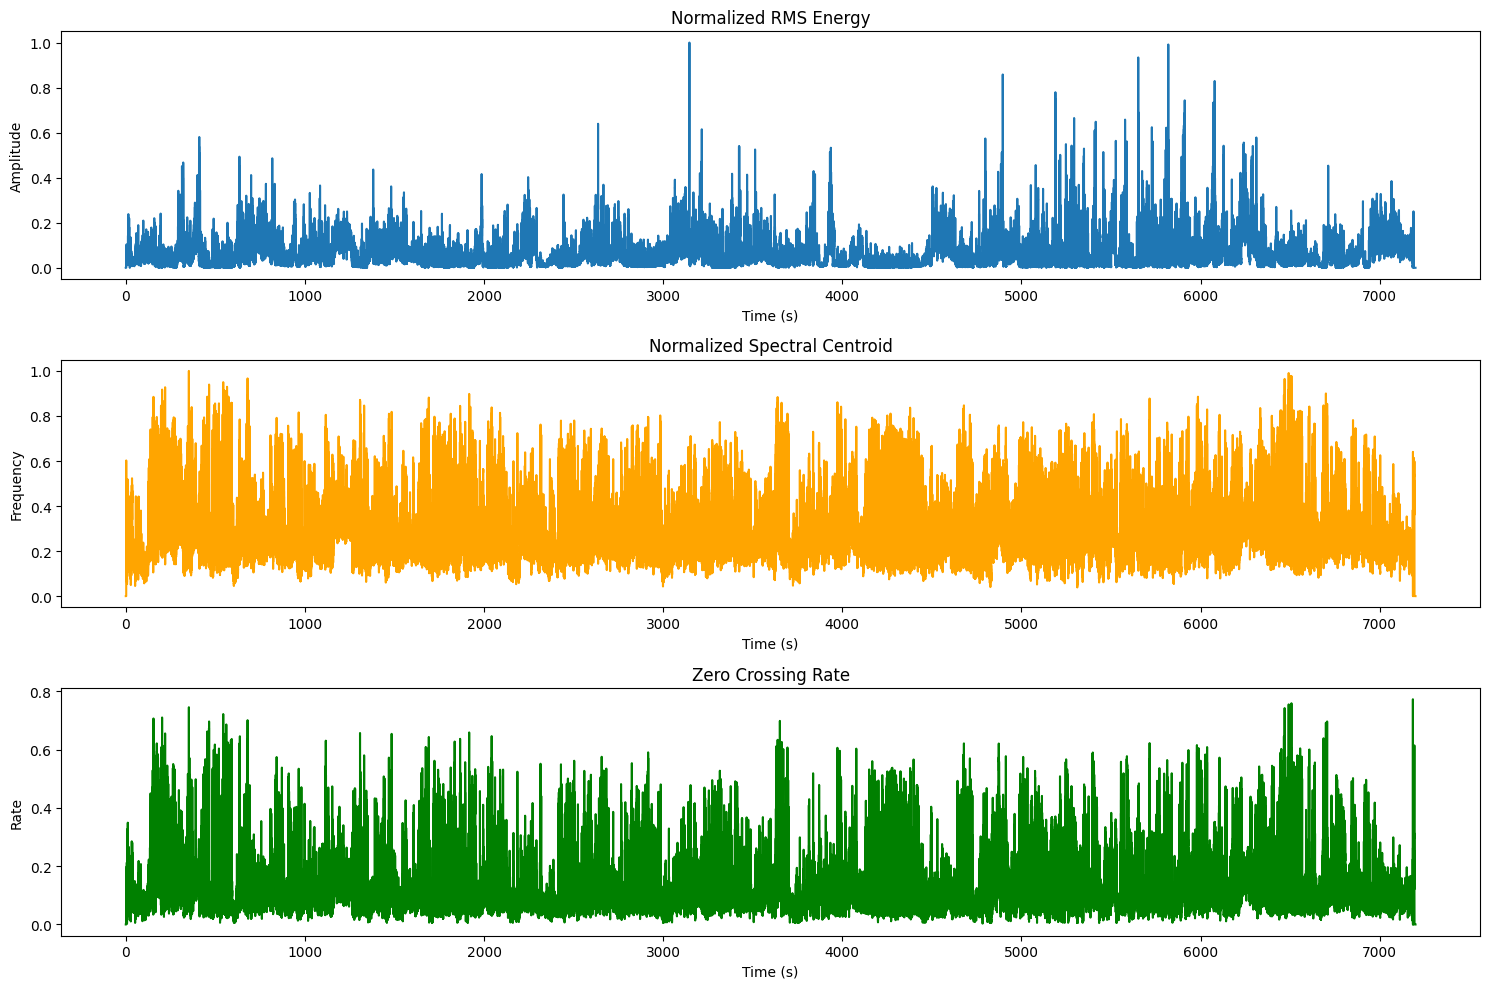

In [8]:
audio_metadata = scene_detector.get_audio_analysis()

Visualizator.plot_audio_metadata(audio_metadata)

На основе полученной информации разобьем фильм на логические аудио сцены. Обращаем внимание на изменения звуковой сцены на основе резких изменений громкости (среднеквадратичная) и «яркости» звука (спектрального центроида) в данных.

In [9]:
audio_scenes = scene_detector.detect_audio_scenes(audio_metadata)

Visualizator.scenes_statistic(audio_scenes, 'audio')

100%|██████████| 310083/310083 [00:00<00:00, 320774.32it/s]

Detected 20 scenes in audio:
	- scene #1: 0.00 - 492.24 (492.24 sec)
	- scene #2: 492.24 - 498.00 (5.76 sec)
	- scene #3: 498.00 - 548.43 (50.43 sec)
	- scene #4: 548.43 - 929.87 (381.43 sec)
	- scene #5: 929.87 - 1469.47 (539.61 sec)
	- scene #6: 1469.47 - 1649.03 (179.56 sec)
	- scene #7: 1649.03 - 1657.46 (8.43 sec)
	- scene #8: 1657.46 - 1751.20 (93.74 sec)
	- scene #9: 1751.20 - 1923.40 (172.20 sec)
	- scene #10: 1923.40 - 2420.01 (496.61 sec)
	- scene #11: 2420.01 - 6469.33 (4049.33 sec)
	- scene #12: 6469.33 - 6492.18 (22.85 sec)
	- scene #13: 6492.18 - 6496.29 (4.11 sec)
	- scene #14: 6496.29 - 6500.80 (4.50 sec)
	- scene #15: 6500.80 - 6508.90 (8.10 sec)
	- scene #16: 6508.90 - 6547.66 (38.75 sec)
	- scene #17: 6547.66 - 6566.35 (18.69 sec)
	- scene #18: 6566.35 - 7185.90 (619.55 sec)
	- scene #19: 7185.90 - 7194.08 (8.17 sec)
	- scene #20: 7194.08 - 7200.16 (6.08 sec)


В фильме 'Home alone' удалось выделить 20 смысловых аудиосцен

## Сегментация по видео 

Теперь попробуем разделить фильм на сцены на основе видеодорожки.
Сцены выделяются, основываясь на изменениях, когда камера переключается на новый кадр, изменение местоположения, освещения или движения. Использует библиотеку PySceneDetect, которая анализирует кадры и определяет переходы на основе изменений в содержимом

In [10]:
video_scenes = scene_detector.detect_video_scenes()

Visualizator.scenes_statistic(video_scenes, 'video')

VideoManager is deprecated and will be removed.


Get video
Detected scenes
Detected 1924 scenes in video:
	- scene #1: 0.00 - 3.25 (3.25 sec)
	- scene #2: 3.25 - 51.01 (47.76 sec)
	- scene #3: 51.01 - 137.89 (86.88 sec)
	- scene #4: 137.89 - 149.32 (11.43 sec)
	- scene #5: 149.32 - 152.15 (2.84 sec)
	- scene #6: 152.15 - 161.12 (8.97 sec)
	- scene #7: 161.12 - 165.58 (4.46 sec)
	- scene #8: 165.58 - 168.92 (3.34 sec)
	- scene #9: 168.92 - 173.17 (4.25 sec)
	- scene #10: 173.17 - 174.76 (1.58 sec)
	- scene #11: 174.76 - 180.93 (6.17 sec)
	- scene #12: 180.93 - 185.23 (4.30 sec)
	- scene #13: 185.23 - 187.15 (1.92 sec)
	- scene #14: 187.15 - 191.15 (4.00 sec)
	- scene #15: 191.15 - 192.82 (1.67 sec)
	- scene #16: 192.82 - 194.74 (1.92 sec)
	- scene #17: 194.74 - 198.28 (3.55 sec)
	- scene #18: 198.28 - 201.41 (3.13 sec)
	- scene #19: 201.41 - 203.33 (1.92 sec)
	- scene #20: 203.33 - 204.79 (1.46 sec)
	- scene #21: 204.79 - 206.54 (1.75 sec)
	- scene #22: 206.54 - 207.83 (1.29 sec)
	- scene #23: 207.83 - 209.13 (1.29 sec)
	- scene #24: 

В результате получилось довольно больше количество сцен, которые можно считать, скорее шортами, а не сценами, поскольку изменения кадра не всегда означает логическую смену сцены. 

Попытаемся агрегировать полученные шоты в более осмысленные сцены. Смонтирует смеждый шоты в одну сцену, если:
- они визуально похожи
- нет резких изменений
- их продолжительность не слишком мала или велика

In [11]:
visual_scenes = scene_detector.detect_visual_scenes(video_scenes)

Visualizator.scenes_statistic(visual_scenes, 'visual')

  0%|          | 0/1923 [00:00<?, ?it/s]

100%|██████████| 1923/1923 [01:21<00:00, 23.74it/s]

Detected 293 scenes in visual:
	- scene #1: 0.00 - 51.01 (51.01 sec)
	- scene #2: 51.01 - 137.89 (86.88 sec)
	- scene #3: 137.89 - 161.12 (23.23 sec)
	- scene #4: 161.12 - 185.23 (24.11 sec)
	- scene #5: 185.23 - 206.54 (21.31 sec)
	- scene #6: 206.54 - 230.40 (23.86 sec)
	- scene #7: 230.40 - 252.54 (22.15 sec)
	- scene #8: 252.54 - 273.77 (21.23 sec)
	- scene #9: 273.77 - 296.05 (22.27 sec)
	- scene #10: 296.05 - 316.98 (20.94 sec)
	- scene #11: 316.98 - 340.84 (23.86 sec)
	- scene #12: 340.84 - 361.24 (20.40 sec)
	- scene #13: 361.24 - 383.38 (22.15 sec)
	- scene #14: 383.38 - 403.61 (20.23 sec)
	- scene #15: 403.61 - 433.64 (30.03 sec)
	- scene #16: 433.64 - 454.04 (20.40 sec)
	- scene #17: 454.04 - 474.31 (20.27 sec)
	- scene #18: 474.31 - 496.33 (22.02 sec)
	- scene #19: 496.33 - 517.85 (21.52 sec)
	- scene #20: 517.85 - 553.68 (35.83 sec)
	- scene #21: 553.68 - 573.99 (20.31 sec)
	- scene #22: 573.99 - 597.97 (23.98 sec)
	- scene #23: 597.97 - 620.04 (22.06 sec)
	- scene #24: 62

В результате получили 293 видеосцены, которые более логично отражают сценарную смену

## Объединение сегментаций

Количество определенных сцен по аудио кратно меньше количества по видео. 

Ключевые принципы
1. Audio scenes важнее с точки зрения смысла. Они определяют крупные смысловые блоки. Если есть граница аудио, то вероятнее всего - это обязательная граница смысла:
    - смена локации
    - смена музыки
    - смена диалога
    - смена настроения

2. Visual scenes — вспомогательное деление. Они могут добавить границу, но не могут убрать аудио-границу


Для каждой звуковой сцены определим все визуальные сцены и создадим новый семантический блок:
- в начале звуковой сцены
- на границе звуковой сцены
- на подтверждённой визуальной границе

In [78]:
semantic_blocks = scene_detector.build_semantic_scenes(audio_scenes, visual_scenes)

Visualizator.scenes_statistic(semantic_blocks, 'semantic blocks')

Detected 293 scenes in semantic blocks:
	- scene #1: 0.00 - 51.01 (51.01 sec)
	- scene #2: 51.01 - 137.89 (86.88 sec)
	- scene #3: 137.89 - 161.12 (23.23 sec)
	- scene #4: 161.12 - 185.23 (24.11 sec)
	- scene #5: 185.23 - 206.54 (21.31 sec)
	- scene #6: 206.54 - 230.40 (23.86 sec)
	- scene #7: 230.40 - 252.54 (22.15 sec)
	- scene #8: 252.54 - 273.77 (21.23 sec)
	- scene #9: 273.77 - 296.05 (22.27 sec)
	- scene #10: 296.05 - 316.98 (20.94 sec)
	- scene #11: 316.98 - 340.84 (23.86 sec)
	- scene #12: 340.84 - 361.24 (20.40 sec)
	- scene #13: 361.24 - 383.38 (22.15 sec)
	- scene #14: 383.38 - 403.61 (20.23 sec)
	- scene #15: 403.61 - 433.64 (30.03 sec)
	- scene #16: 433.64 - 454.04 (20.40 sec)
	- scene #17: 454.04 - 474.31 (20.27 sec)
	- scene #18: 474.31 - 498.00 (23.69 sec)
	- scene #19: 498.00 - 517.85 (19.85 sec)
	- scene #20: 517.85 - 548.43 (30.58 sec)
	- scene #21: 548.43 - 573.99 (25.56 sec)
	- scene #22: 573.99 - 597.97 (23.98 sec)
	- scene #23: 597.97 - 620.04 (22.06 sec)
	- scen

В качестве финального шага добавим CLIP similarity - объединим визуальные эмбеддинги по treshold==0.8. 

Критерии объединения:
- короткая сцена
- высокое визуальное сходство

In [54]:
merge_scenes = scene_detector.merge_scenes_cosine(semantic_blocks)

Visualizator.scenes_statistic(merge_scenes, 'final merge scenes')

100%|██████████| 292/292 [00:12<00:00, 23.28it/s]

Detected 254 scenes in final merge scenes:
	- scene #1: 0.00 - 137.89 (137.89 sec)
	- scene #2: 137.89 - 161.12 (23.23 sec)
	- scene #3: 161.12 - 185.23 (24.11 sec)
	- scene #4: 185.23 - 252.54 (67.32 sec)
	- scene #5: 252.54 - 273.77 (21.23 sec)
	- scene #6: 273.77 - 296.05 (22.27 sec)
	- scene #7: 296.05 - 316.98 (20.94 sec)
	- scene #8: 316.98 - 340.84 (23.86 sec)
	- scene #9: 340.84 - 361.24 (20.40 sec)
	- scene #10: 361.24 - 383.38 (22.15 sec)
	- scene #11: 383.38 - 403.61 (20.23 sec)
	- scene #12: 403.61 - 433.64 (30.03 sec)
	- scene #13: 433.64 - 454.04 (20.40 sec)
	- scene #14: 454.04 - 474.31 (20.27 sec)
	- scene #15: 474.31 - 498.00 (23.69 sec)
	- scene #16: 498.00 - 517.85 (19.85 sec)
	- scene #17: 517.85 - 548.43 (30.58 sec)
	- scene #18: 548.43 - 573.99 (25.56 sec)
	- scene #19: 573.99 - 597.97 (23.98 sec)
	- scene #20: 597.97 - 620.04 (22.06 sec)
	- scene #21: 620.04 - 645.35 (25.32 sec)
	- scene #22: 645.35 - 669.88 (24.52 sec)
	- scene #23: 669.88 - 694.03 (24.15 sec)
	

Оценим результат более наглядно

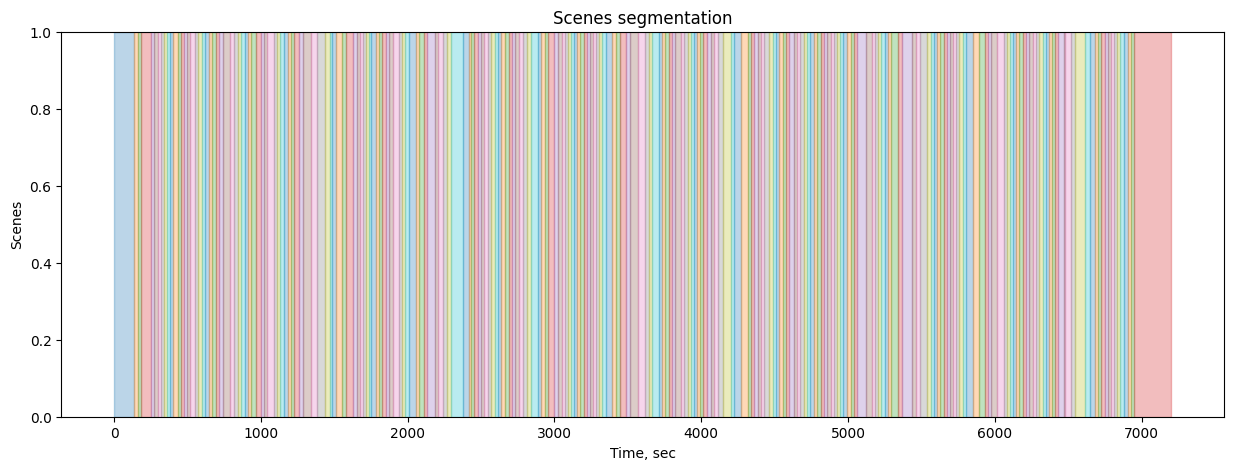

In [77]:
Visualizator.visualize_scenes(merge_scenes, VIDEO_PATH)

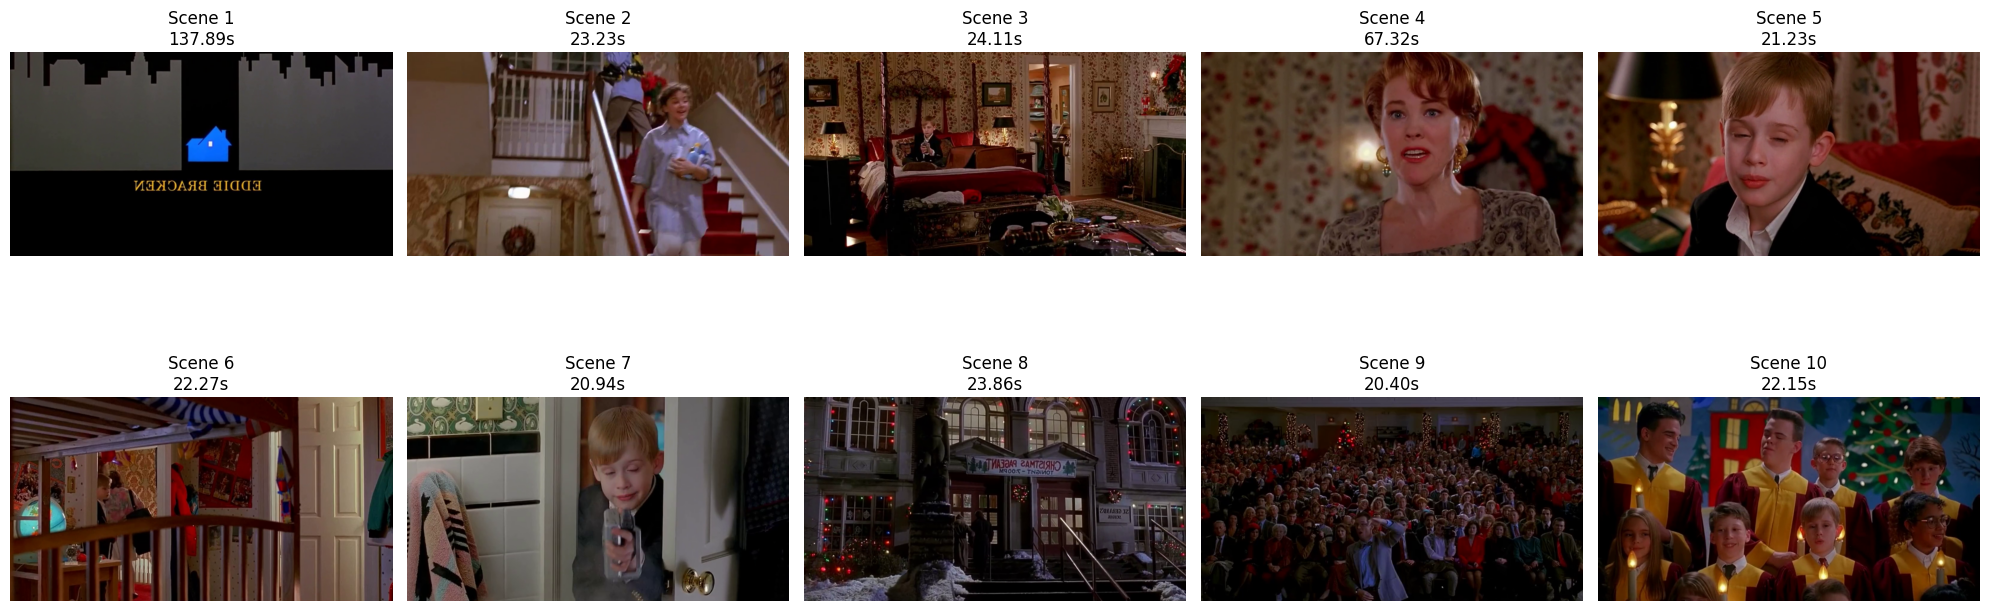

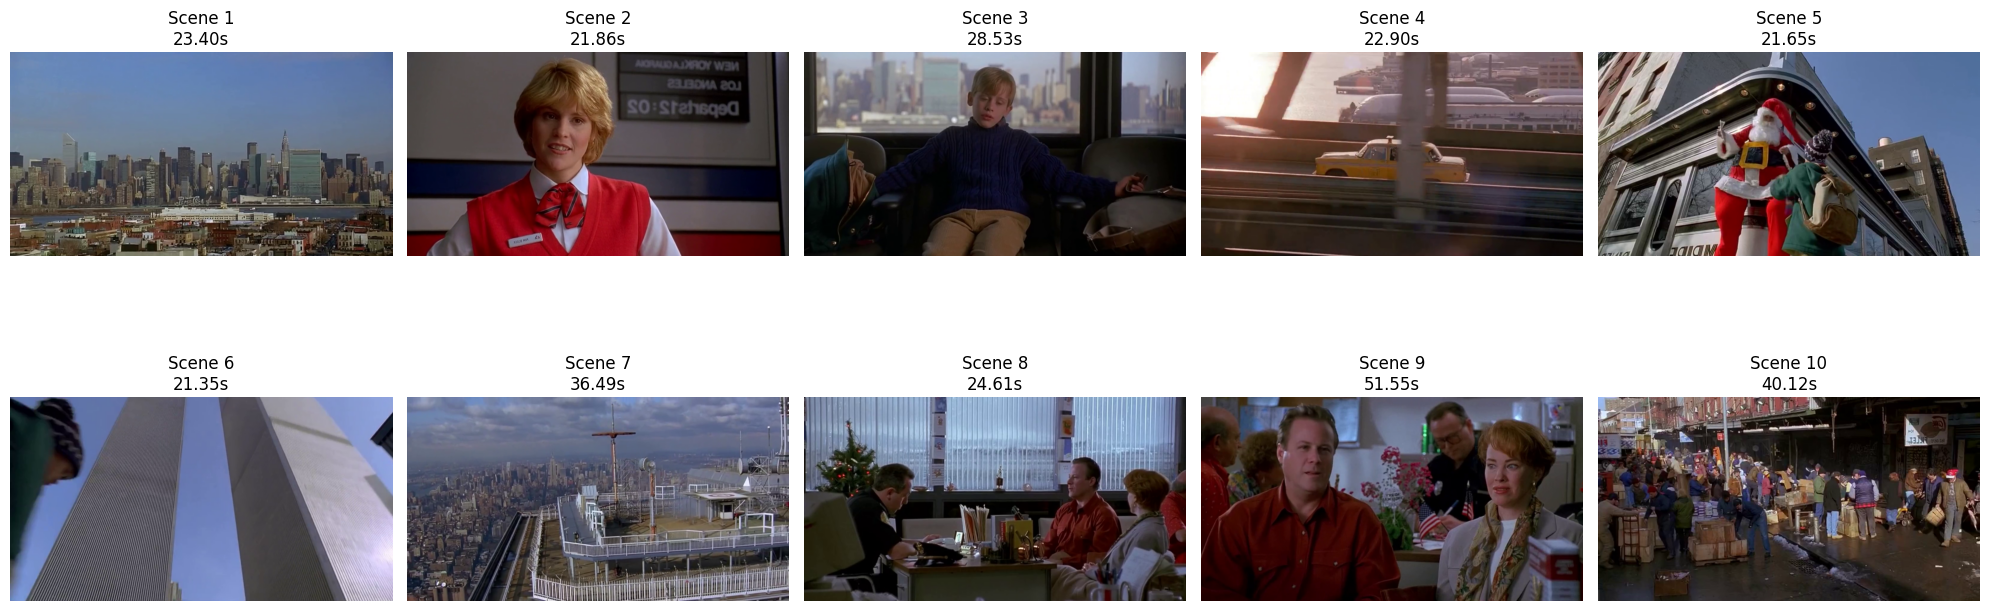

In [66]:
Visualizator.show_middle_frame_of_ten(merge_scenes[0:10])
Visualizator.show_middle_frame_of_ten(merge_scenes[37:47])

Дальнейшая доработка зависит от сферы применения технологии. Если задача заключается в определении именно смысловых сцен, то можно также учесть:
- смену локации с детекцией конкретных предметов
- долгое отсутствие диалога
- начало музыки / экшена
- Automatic Speech Recognition (ASR)

Если же механизм будет использоваться для деления фильма на кадры относительно присутствия тех или иных актеров, то имеет смысл добавить детекцию лиц.

# Детекция и треккинг

Фильм 'Home alone' является довольно интересным в разрезе решения задач детекции. Персонажи строят гримассы, цветокор сильно разнится в зависимости от ситуации, происходит частая смена локаций... - все это необходимо учитывать в алгоритме.

В первом приближении определим персонажей по трейлеру фильма

In [6]:
# FILENAME = 'one_alone'      # full move
FILENAME = 'one_alone_t'  # trailer

SOURCES_PATH = './sources/'
VIDEO_PATH = SOURCES_PATH + FILENAME + '.mp4'
AUDIO_PATH = SOURCES_PATH + FILENAME + '.wav'

## Основной подход

Выполним детекцию лиц на основе модели yolov8n-face с последующим определением персонажа с применением FaceAnalysis модель buffalo_l. 

Основные шаги:
1. Детекция лиц на кадре с помощью YOLO
2. Более точно определяем границу лица
3. Производим нормализацию яркости/контраста и повышаем резкость
4. Вычисляем эмбеддинг с помощью buffalo_l
5. Вычисляем косинусное расстояние со всеми накопленными лицами из базы и определяем id персонажа
6. Сохраняем лицо и его эмбеддинг в папку по соотвутствующему id-шнику 

In [8]:
class FaceDetector:
    def __init__(
        self, yolo_modelname='yolov8n-face.pt', insightface_modelname='buffalo_l',
        pictures_savedir='./sources/detected_faces'
    ):
        self.face_tracks = {}  # {face_id: {'emb': emb, 'last_seen': frame, 'count': n}}

        self.next_unique_id = 1

        # Create YOLO face detector
        self.m_yolo = YOLO(yolo_modelname)
        if torch.cuda.is_available():
            self.m_yolo.to('cuda')


        # ~~~~~ [Experiment] Create insightfaces with diff det_sizes
        # self.insightfaces = {}
        # det_sizes = [(640,640), (512,512), (448,448), (320,320)]
        # for i, det_size in enumerate(det_sizes):
        #     model = FaceAnalysis(name=insightface_modelname)
        #     model.prepare(ctx_id=0, det_size=det_size)
        #     self.insightfaces[det_size] = model
        #     print(f"Loaded InsightFace det_size={det_size}")
        # ~~~~~~
        self.det_size = 224
        self.m_insightface = FaceAnalysis(name=insightface_modelname)
        self.m_insightface.prepare(ctx_id=0, det_size=(self.det_size, self.det_size))

        self.faces_savedir = pictures_savedir
        os.makedirs(self.faces_savedir, exist_ok=True)

    # def _get_face_emb(self, face_img):
    #     '''Parallel searching by diff det_size models'''
    #     for _, model in self.insightfaces.items():
    #         faces = model.get(face_img)
    #         if len(faces) > 0:
    #             return faces[0].embedding
    #     return None

    def _preprocess_face(self, face_img):
        """Normalize brightness/contrast + sharpening"""
        # plt.imshow(cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB))
        # plt.axis('off')
        # plt.show()
        
        lab = cv2.cvtColor(face_img, cv2.COLOR_BGR2LAB)
        clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8,8))
        lab[:,:,0] = clahe.apply(lab[:,:,0])
        preprocc_face_img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
        
        # plt.imshow(cv2.cvtColor(preprocc_face_img, cv2.COLOR_BGR2RGB))
        # plt.axis('off')
        # plt.show()
        return preprocc_face_img

    def _get_face_emb(self, face_img):
        faces = self.m_insightface.get(face_img)
        if len(faces) == 0:
            return None
        return faces[0].embedding
    
    def _get_same_id(self, face_emb, threshold):
        finall_best_id = None
        best_score = 0.0

        if len(self.face_tracks):
            similarities = {
                face_id: np.dot(face_emb, data['emb']) / (np.linalg.norm(face_emb) * np.linalg.norm(data['emb']))
                for face_id, data in self.face_tracks.items()
            }

            best_id, best_score = max(similarities.items(), key=lambda x: x[1])

            if best_score > threshold:
                finall_best_id = best_id
            
        return finall_best_id, best_score
    
    def _detect_faces_with_smoothing(self, face_emb, n_frame, threshold):
        '''Faces with close embeddings in adjacent frames == one ID'''

        # 1. Get same face id
        best_id, best_score = self._get_same_id(face_emb, threshold)

        # 2. Create new track
        if best_id is None:
            best_id = self.next_unique_id
            self.face_tracks[best_id] = {'emb': face_emb, 'last_seen': n_frame, 'count': 1}
            self.next_unique_id += 1

        # 3. Or update current track if it's found:
        #   - Smoothing the embedding using an exponential moving average (EMA)
        #   - Update track to actual current_frame
        #   - Increasing the number of faces seen 
        else:
            self.face_tracks[best_id]['emb'] = 0.9 * self.face_tracks[best_id]['emb'] + 0.1 * face_emb
            self.face_tracks[best_id]['last_seen'] = n_frame
            self.face_tracks[best_id]['count'] += 1

        return best_id, best_score

    def _save_face(self, face_id, best_score, face_img, face_emb, save_face_threshold):
        if best_score < save_face_threshold:
            folder = os.path.join(self.faces_savedir, str(face_id))
            os.makedirs(folder, exist_ok=True)

            # 1. Save image
            img_folder = os.path.join(folder, 'images')
            os.makedirs(img_folder, exist_ok=True)
            img_path = os.path.join(img_folder, f'{len(os.listdir(img_folder))}.jpg')
            cv2.imwrite(img_path, face_img)

            # 2. Save embedding
            emb_folder = os.path.join(folder, 'embs')
            os.makedirs(emb_folder, exist_ok=True)
            emb_path = os.path.join(emb_folder, f'{len(os.listdir(emb_folder))}.npy')
            np.save(emb_path, face_emb)

    def detect(
        self, video_path,
        m_yolo_confidence_threshold=0.5,
        is_person_threshold=0.4,
        imgsz=1280,  # for small faces
        iou_threshold=0.5,  # for overlapping boxes
        padding_ratio=0.05,
        save_face_threshold=0.7,
        min_face_size = 60,
        is_visualize=True
    ):
        cap = cv2.VideoCapture(video_path)

        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        pbar = tqdm(total=total_frames)

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # 1. Detect faces with YOLO
            results = self.m_yolo(
                frame, 
                verbose=False,
                conf=m_yolo_confidence_threshold,
                iou=iou_threshold,
                imgsz=imgsz
            )[0]

            # [Optional] loging of every 30 frames
            # if pbar.n % 30 == 0:
            #     scores = [b[4] for b in results.boxes.data.tolist()]
            #     print(f"Frame {pbar.n}: {len(results.boxes)} boxes, "
            #           f"scores={[f'{s:.2f}' for s in scores[:5]]}{'...' if len(scores)>5 else ''}")

            for box in results.boxes.data.tolist():
                x1, y1, x2, y2, score, _ = box
                # if score < m_yolo_confidence_threshold:
                #     continue

                face_w, face_h = x2-x1, y2-y1
                if face_w < min_face_size or face_h < min_face_size:
                    continue

                # 2. Crop padding
                h, w = int(y2-y1), int(x2-x1)
                pad_h, pad_w = int(h * padding_ratio), int(w * padding_ratio)

                # Extended crop with boundary checking and preprocessing
                x1_pad = max(0, int(x1 - pad_w))
                y1_pad = max(0, int(y1 - pad_h))
                x2_pad = min(frame.shape[1], int(x2 + pad_w))
                y2_pad = min(frame.shape[0], int(y2 + pad_h))

                face_img = frame[y1_pad:y2_pad, x1_pad:x2_pad]
                face_img = self._preprocess_face(face_img)

                # 3. Extract face and it's embedding with InsightFace
                face_emb = self._get_face_emb(face_img)
                if face_emb is None:
                    continue

                # 4. Compare with existing faces in DB
                matched_id, best_score = self._detect_faces_with_smoothing(
                    face_emb, pbar.n, is_person_threshold
                )
                
                # 4. Save new face picture
                self._save_face(matched_id, best_score ,face_img, face_emb, save_face_threshold)

                if is_visualize:
                    # Visualization with padding
                    cv2.putText(frame, f"ID {matched_id} ({score:.2f})", 
                            (int(x1_pad), int(y1_pad)-10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)
                    cv2.rectangle(frame, (int(x1_pad), int(y1_pad)), 
                                (int(x2_pad), int(y2_pad)), (0,255,0), 2)

            if is_visualize:
                cv2.imshow('Face ID system [conf=0.25, pad=0.2, imgsz=1280]', frame)
                if cv2.waitKey(1) == 27:  # ESC
                    break
            pbar.update(1)

        cap.release()
        pbar.close()
        cv2.destroyAllWindows()

In [ ]:
# [OPTIONAL] Load yolov8n-face

# import urllib.request

# url = "https://github.com/YapaLab/yolo-face/releases/download/v0.0.0/yolov8n-face.pt"
# urllib.request.urlretrieve(url, "yolov8n-face.pt")

In [ ]:
# [OPTIONAL] Free faces folder

# !rm -rf sources/detected_faces/*

In [9]:
try: del face_detector # delete if exists
except: print('FaceDetector obj does not exist')

face_detector = FaceDetector()

FaceDetector obj does not exist


/home/devuser/.local/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/devuser/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/devuser/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/devuser/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/devuser/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/devuser/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127

Важные нюансы:
- Сосредотачиваемся на лицах более 60*60 (настраиваемый параметр)
- В процессе поиска и доработок была попытка использовать динамический `det_size` для `FaceAnalysis` в зависимости от размера найденного лица, однако такой подход оказался несовсем корректен
- Для лиц одного персонажа формировался единый трек с единым эмбеддингом. Условия обновления трека:
    - Сглаживание эмбеддинга с использованием экспоненциального скользящего среднего (EMA)
    - Обновление трека до фактического текущего кадра
    - Увеличение количества увиденных лиц 
- Вычисления моделей `YOLO` и `FaceAnalysis` переведены на GPU (NVIDIA GeForce RTX 5060 Laptop - 8 GB), что значительно сказалось на скорости работы алгоритма

Для визуализации и покадрового треккинга необходимо передать `is_visualize=True`

In [103]:
face_detector.detect(VIDEO_PATH)#, is_visualize=False)

  0%|          | 8/3523 [00:03<12:08,  4.83it/s]  /home/devuser/.local/lib/python3.10/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4
100%|██████████| 3523/3523 [11:39<00:00,  5.03it/s] 


На данных конфигурациях детекция на трейлере ~2 минут проходила ~9 минут. Следовательно, чтобы выделить лица из всего ~2 часового фильма (120 минут) потребуется ~9 часов, что в принципе не слишком много с учетом вводных. При увеличении количества GB на GPU и распараллеливании вычислений текущий алгоритм может отрабатывать кратно быстрее - мгновенно по меркам CV - что безусловно является преимуществом

In [8]:
# Count of final face detections
len(face_detector.face_tracks)

74

Нам удалось выделить 74 уникальных id. Посмотрим распределение по папкам: какие id-шники оказались наиболее популярными?

In [10]:
imgs_count = {'dirname': [], 'imgs_count': []}

for dir in os.listdir(face_detector.faces_savedir):
    imgs_count['dirname'].append(dir)
    imgs_count['imgs_count'].append(
        len(os.listdir(os.path.join(face_detector.faces_savedir, dir, 'images')))
    )


id_img_count = pd.DataFrame(imgs_count).sort_values(['imgs_count', 'dirname'], ascending=[False, True])

In [11]:
id_img_count.head(50)

dirname  imgs_count
66       2          68
62      24          42
17      47          31
15      25          29
10       5          26
4       27          25
38       4          17
7       46          14
23      48          14
26      17          13
60      10          12
16      54          12
71       9          12
18      28          11
9       22          10
37      15           9
3       66           9
36      13           8
32      73           8
55      14           7
21      26           7
13       7           7
46      12           6
25      18           6
6       59           6
72      62           6
52      72           6
28      69           5
41      16           4
27      23           4
56      53           4
0       58           4
50      64           4
48      67           4
12      70           4
49      39           3
29      41           3
11      55           3
69      60           3
5       71           3
19      31           2
20      42           2
33      44           2
31      45           2
65      56           2
51       1           1
58      11           1
70      19           1
1       20           1
35      21           1

Выведем топ 3 самых частовстречающихся персонажа

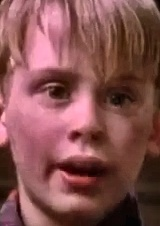

None

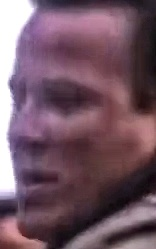

None

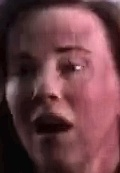

None

In [102]:
def show_face(id):
    dir = os.path.join(face_detector.faces_savedir, id, 'images')
    img = Image.open(os.path.join(dir, sorted(os.listdir(dir))[-1]))
    display(img.show())


show_face('2')
show_face('24')
show_face('47')

## Финальное определение лиц

Проведем финальную оценку близости и объединим одинаковых персонажей на основе обобщенного эмбеддинга папки

Создадим единый эмбеддинг для всех лиц по id папки

In [ ]:
faces = {} # {id: emb}

for id in os.listdir(face_detector.faces_savedir):
    emb_dir = os.path.join(face_detector.faces_savedir, id, 'embs')
    emb = None

    for emb_filename in os.listdir(emb_dir):
        current_emb = np.load(os.path.join(emb_dir, emb_filename))
        emb = (0.9 * emb + 0.1 * current_emb) if emb is not None else current_emb
    faces[id] = emb


len(faces)
       

74

In [13]:
mtx_faces_cosine_similarity = cosine_similarity(list(faces.values()))
df_similarity = pd.DataFrame(mtx_faces_cosine_similarity, index=list(faces.keys()), columns=list(faces.keys()))

Определим косинусные расстояния каждого к каждому - близкие пары

In [95]:
high_similarities  = df_similarity[(df_similarity >= 0.47) & (df_similarity < 1.0)].stack()
pairs = high_similarities.reset_index()
pairs.columns = ['id1', 'id2', 'cosine_similarity']
pairs = pairs[pairs['id1'] < pairs['id2']]

pairs['id1'] = pairs['id1'].astype(int)
pairs['id2'] = pairs['id2'].astype(int)
pairs = pairs.sort_values(['id1', 'id2'])


pairs

id1  id2  cosine_similarity
48    2   57           0.584397
27    4   53           0.534135
29   12   48           0.505721
25   13   51           0.473810
16   17   24           0.638092
23   21   22           0.494745
43   24   41           0.575984
8    25    5           0.613827
9    25   47           0.598853
32   39   44           0.632356
10   47    5           0.747483

Сгруппируем в граф по принципу связных компонент

In [96]:
# Create graph
G = nx.Graph()
edges = pairs[['id1', 'id2']].values.tolist()
G.add_edges_from(edges)

# Find binding components
components = list(nx.connected_components(G))

display(components)


[{2, 57},
 {4, 53},
 {12, 48},
 {13, 51},
 {17, 24, 41},
 {21, 22},
 {5, 25, 47},
 {39, 44}]

Отрисуем найденные совпадения лиц

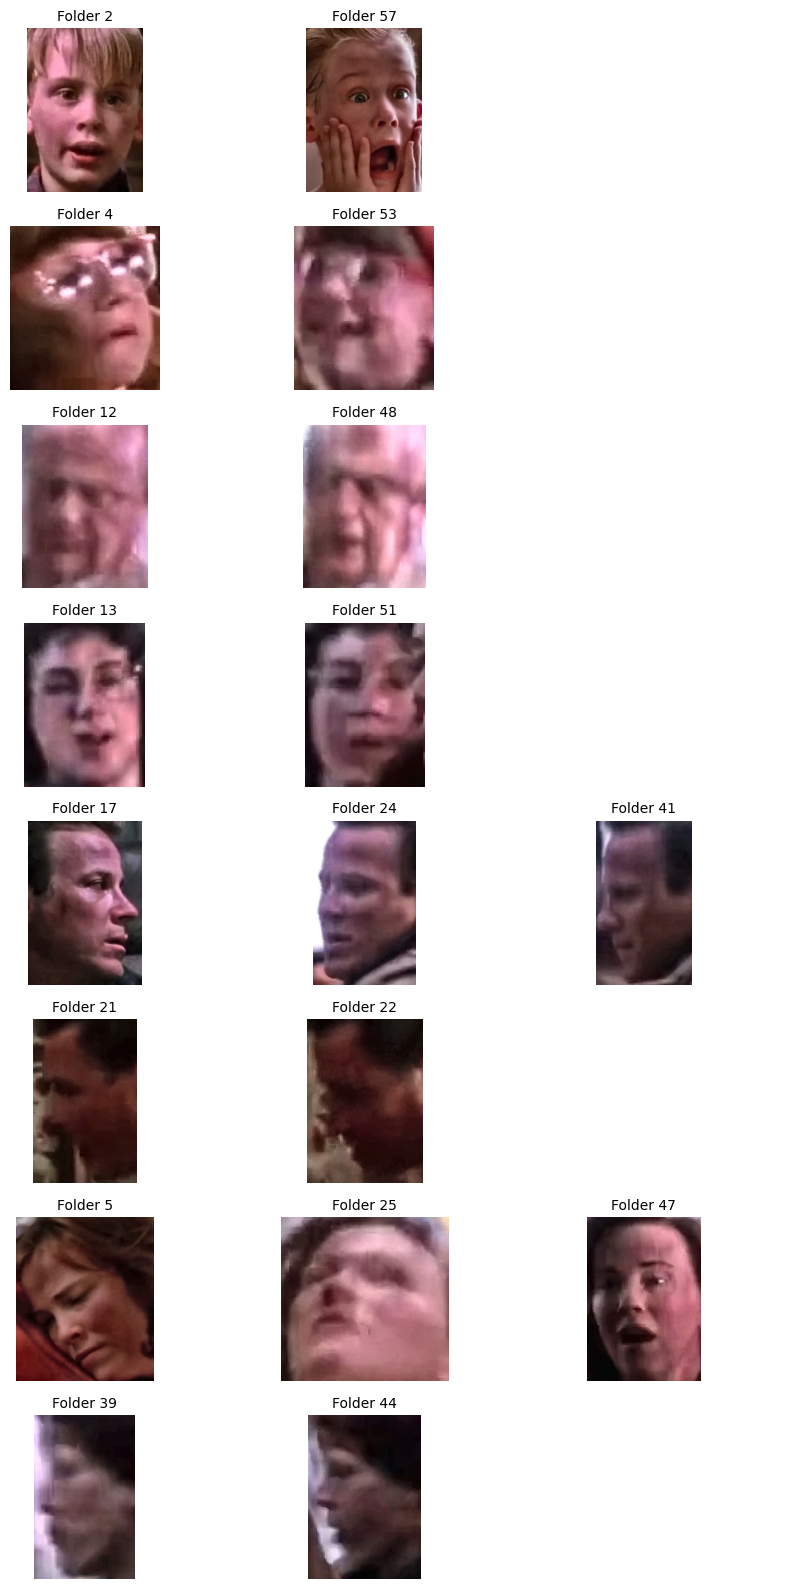

In [98]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from pathlib import Path

# Создаем фигуру с рядами = len(sets), колонки = max размер сета
max_cols = max(len(s) for s in components)
fig, axes = plt.subplots(len(components), max_cols, figsize=(3*max_cols, 2*len(components)))

# Если один ряд — axes не массив, исправляем
if len(components) == 1:
    axes = axes.reshape(1, -1)

for row_idx, folder_set in enumerate(components):
    for col_idx, folder_id in enumerate(sorted(folder_set)):
        ax = axes[row_idx, col_idx]
        
        # Get last face
        folder_path = os.path.join(face_detector.faces_savedir, f'./{folder_id}/', 'images')
        img_path = os.path.join(folder_path, sorted(os.listdir(folder_path))[-1])
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.set_title(f'Folder {folder_id}', fontsize=10)
        
        ax.axis('off')
    
    # Пустые subplot'ы для коротких рядов
    for col_idx in range(len(folder_set), max_cols):
        axes[row_idx, col_idx].axis('off')

plt.tight_layout()
plt.show()


Таким образом удалось вычеслить схожие лица в разных папках, объединение которых положительно повлиет на дальнейшую работу

Детекция лиц на трейлире может быть использована в решении сразу нескольких задач:
1. На данных можно сформировать датасет
2. Данные можно разметить и использовать в качестве датасета для дообучения моделей алгоритма
3. На нем можно проверить качество детекции, сравнив стоковые снимки актеров с задетекченными лицами